In [36]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import RobustScaler
from colorama import Fore
from sklearn import metrics
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score, f1_score, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA 
import math
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
# Set random seed for reproducibility
RANDOM_STATE = 0

# Load dataset

In [51]:
# Load data
data = pd.read_csv('../clean_data/BigDS_train.csv')

# Separate features and target
X = data.drop(columns=['Price'])
y = data['Price']

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)

# Reset indices
for df in (X_train, X_val, y_train, y_val):
    df.reset_index(drop=True, inplace=True)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


testset = pd.read_csv('../clean_data/BigDS_test.csv')
X_test = testset.drop('Price', axis = 1)
y_test = testset['Price']

In [5]:
def plot(predictions):
    sns.distplot(y_test-predictions)
    
    fig1, ax = plt.subplots(1, 1, figsize=(20, 5))

    ax.plot([i for i in range(250)], y_test[0:250],  color='blue')
    ax.plot([i for i in range(250)], predictions[0:250], color='orange')

    ax.set_ylabel("Price (VND)")
    ax.legend(['true price', 'predict price'])

    fig1.show()
    
    fig2, ax = plt.subplots(1, 1, figsize=(20, 5))

    ax.scatter([i for i in range(250)], y_test[0:250],  color='blue', linewidths=4)
    ax.scatter([i for i in range(250)], predictions[0:250], color='orange', linewidths=3)
    
    ax.set_ylabel("Price (VND)")
    ax.legend(['true price', 'predict price'])
    
    fig2.show()

## Phân chia train set và validation set

### Hàm này dùng để đánh giá mô hình

### Sử dụng 3 metrics: MAE, RMSE và MAPE để nhanh chóng đánh giá sơ bộ kết quả của mô hình

In [6]:
def models_score(x_train, x_val, y_train, y_val):    
    models = {
        "RandomForest":RandomForestRegressor(),
         }
    evalutes = {}
    i = 0
    maes = []
    rmse = []
    mape = []
    names = []
    for name, model in models.items():
        model.fit(x_train, y_train)
        y_pred=model.predict(x_val) 
        names.append(name)
        maes.append(mean_absolute_error(y_val,y_pred))
        rmse.append(math.sqrt(mean_squared_error(y_val,y_pred)))
        mape.append(mean_absolute_percentage_error(y_val, y_pred))
    evalutes = {'Algorithms': names, 'MAE': maes, 'RMSE': rmse, "MAPE":mape}
    model_scores = pd.DataFrame(evalutes)
    return model_scores

## Feature Extraction

### Khảo sát hiệu suất mô hình trước khi thực hiện trích xuất đặc trưng

In [7]:
score = models_score(X_train_scaled, X_val_scaled, y_train, y_val)
score

,Algorithms,MAE,RMSE,MAPE
0,RandomForest,338896.743801,529089.005792,0.120218


### Sử dụng PCA để giảm chiều dữ liệu

In [8]:
scores = []
for i in range(1, 15):
  pca = PCA(n_components=i)
  pca.fit(X_train)
  X_train_pca = pca.transform(X_train_scaled)
  X_val_pca = pca.transform(X_val_scaled)
  scores.append(models_score(X_train_pca, X_val_pca, y_train, y_val))


# best_score
print(len(scores))
for score in scores:
  print(score)
best_score = scores[-2] 

14
     Algorithms           MAE          RMSE      MAPE
0  RandomForest  1.753525e+06  2.394239e+06  0.691065
     Algorithms           MAE          RMSE     MAPE
0  RandomForest  1.224040e+06  1.681650e+06  0.48842
     Algorithms           MAE          RMSE      MAPE
0  RandomForest  1.264714e+06  1.694462e+06  0.501962
     Algorithms           MAE          RMSE      MAPE
0  RandomForest  1.348120e+06  1.752910e+06  0.524421
     Algorithms           MAE          RMSE      MAPE
0  RandomForest  1.302782e+06  1.709072e+06  0.501556
     Algorithms            MAE           RMSE      MAPE
0  RandomForest  519040.163735  758306.253374  0.182488
     Algorithms            MAE           RMSE    MAPE
0  RandomForest  447458.432136  664423.341041  0.1565
     Algorithms            MAE           RMSE      MAPE
0  RandomForest  407257.014859  608186.928577  0.143782
     Algorithms            MAE           RMSE      MAPE
0  RandomForest  397542.247715  602083.312446  0.138652
     Algorithms

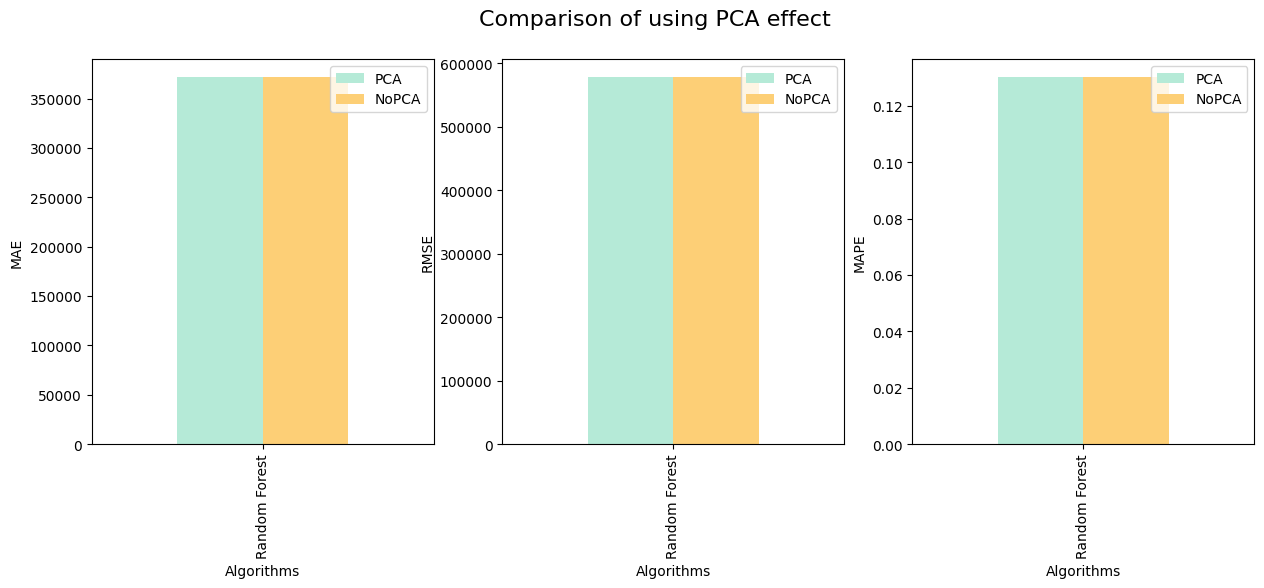

In [9]:
metrics = ["MAE", "RMSE", "MAPE"]
fig, axs = plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Comparison of using PCA effect', fontsize=16) 
for i in range(len(metrics)):
    df_comparea_pca = pd.DataFrame({
        'Algorithms': ["Random Forest"],
        'PCA': [best_score[metrics[i]][0]],
        'NoPCA': [best_score[metrics[i]][0]],
    })
    df_comparea_pca.plot(x="Algorithms", y=["PCA", "NoPCA"], kind="bar", ax = axs[i], color=['#b5ead7', '#fdcf76']
)
    axs[i].set_ylabel(metrics[i])

=> PCA không cải thiện nhiều hiệu suất mô hình, vậy nên chúng ta không áp dụng PCA

## Feature Selection

In [10]:
# df = pd.concat([trainset, valset], axis = 0)
df.reset_index(inplace=True, drop=True)
df_X = data.drop('Price', axis = 1)
df_Y = data['Price']

In [11]:
def feature_importance(ml_model):
    print('Model: {}'.format(ml_model))
    model = ml_model.fit(df_X, df_Y)
    plt.figure(figsize=(15,10))
    feat_importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending = True)
    feat_importances.plot(kind='barh')
    plt.show()

Model: RandomForestRegressor(random_state=42)


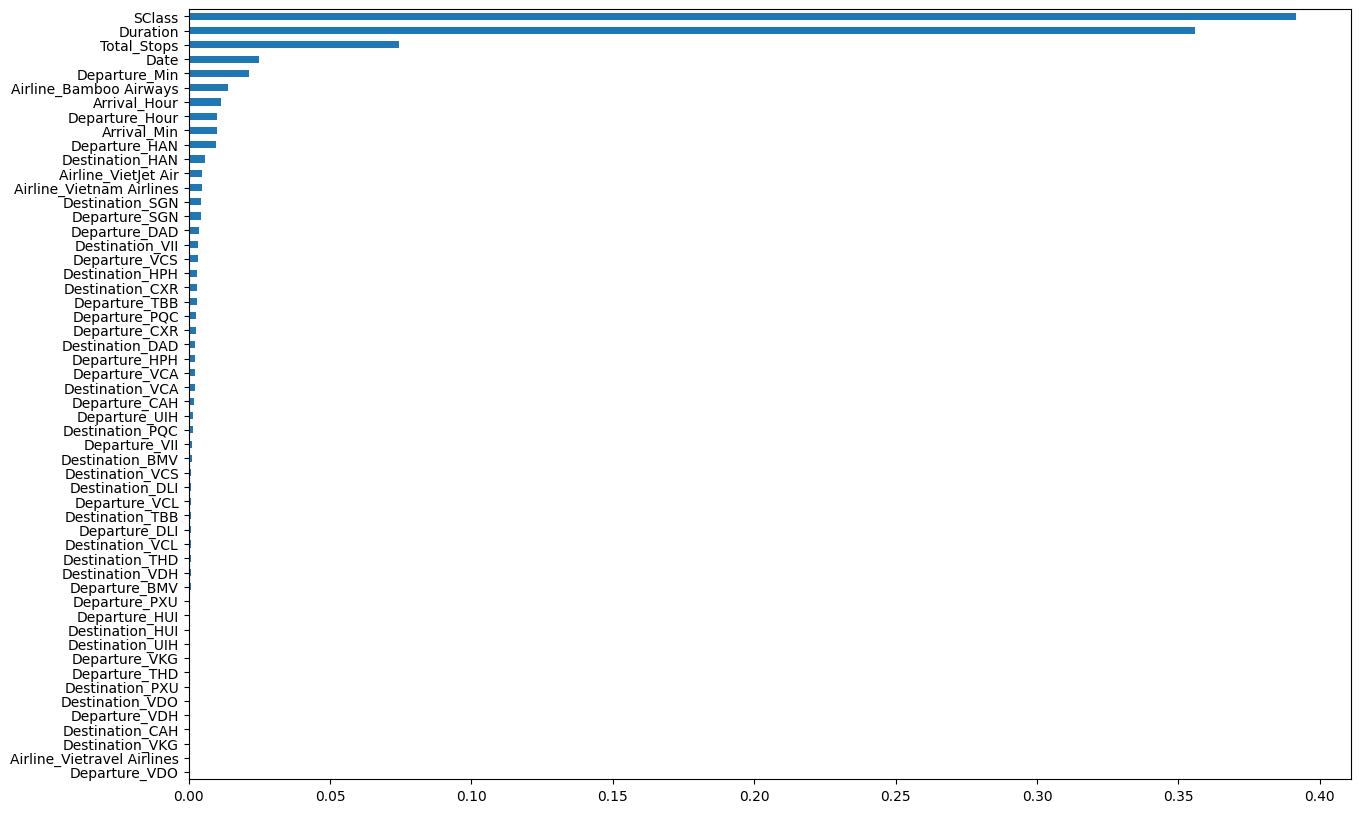

In [12]:
rf = RandomForestRegressor(random_state=42)
feature_importance(rf)

### Đối với mô hình Random Forest


Feature: 0, Score: 0.36467
Feature: 1, Score: 0.02345
Feature: 2, Score: 0.06011
Feature: 3, Score: 0.39545
Feature: 4, Score: 0.01008
Feature: 5, Score: 0.02116
Feature: 6, Score: 0.01165
Feature: 7, Score: 0.01114
Feature: 8, Score: 0.01427
Feature: 9, Score: 0.00511
Feature: 10, Score: 0.00780
Feature: 11, Score: 0.00006
Feature: 12, Score: 0.00065
Feature: 13, Score: 0.00196
Feature: 14, Score: 0.00253
Feature: 15, Score: 0.00394
Feature: 16, Score: 0.00102
Feature: 17, Score: 0.00846
Feature: 18, Score: 0.00213
Feature: 19, Score: 0.00061
Feature: 20, Score: 0.00304
Feature: 21, Score: 0.00061
Feature: 22, Score: 0.00426
Feature: 23, Score: 0.00257
Feature: 24, Score: 0.00040
Feature: 25, Score: 0.00122
Feature: 26, Score: 0.00186
Feature: 27, Score: 0.00160
Feature: 28, Score: 0.00277
Feature: 29, Score: 0.00024
Feature: 30, Score: 0.00003
Feature: 31, Score: 0.00127
Feature: 32, Score: 0.00054
Feature: 33, Score: 0.00111
Feature: 34, Score: 0.00006
Feature: 35, Score: 0.00308
Fe

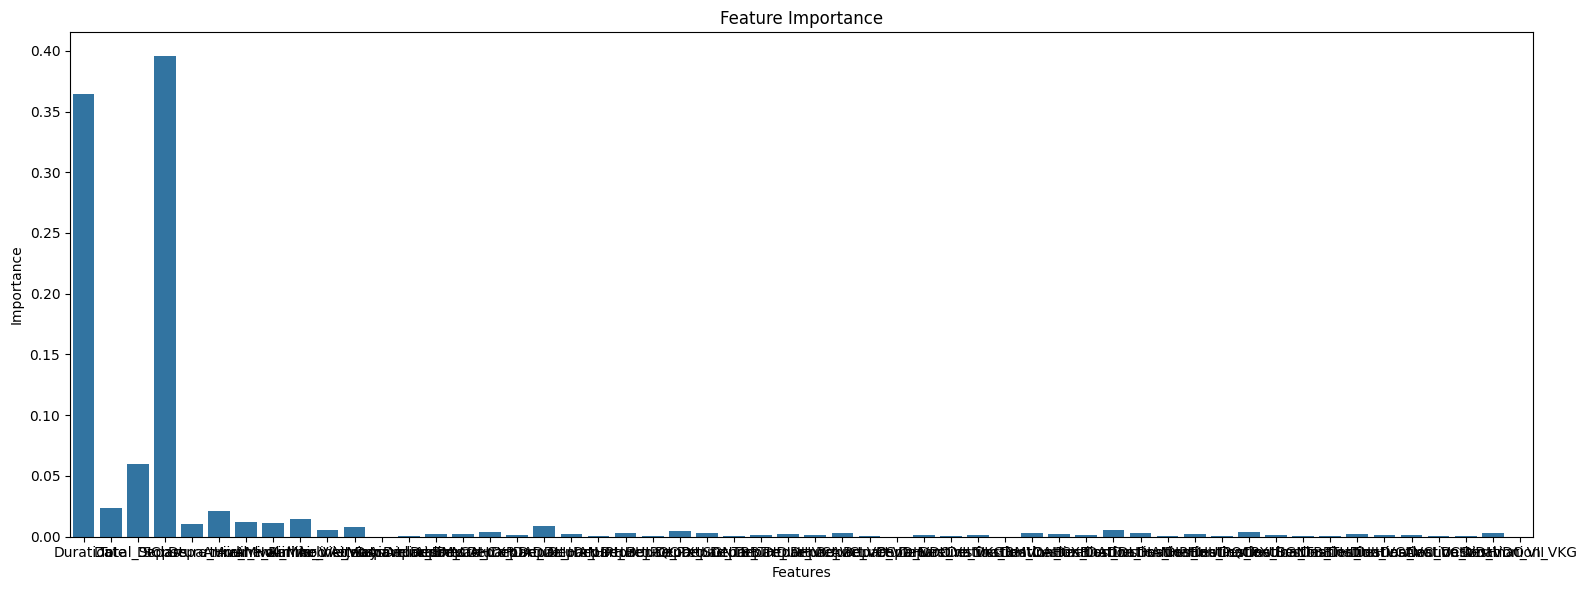

In [13]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

plt.figure(figsize=(16, 6)) 
sns.barplot(x=list(X_train.columns), y=importance)


plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importance")

plt.tight_layout()
plt.show()

### Từ đây, ta thấy được top 3 feature cho mô hình random forest là: 
 - Duration
 - Total_stop
 - SClass


### Ngoài ra, từ kết quả EDA, ta thấy 2 biến Pool và Bar cũng có ảnh hưởng đến biến mục tiêu, vậy nên ta sẽ chọn thêm 1 biến Pool và Bar
=> Như vậy, 2 mô hình của chúng ta sẽ có 7 features:
- Size
- Distance to beach
- Distance to airport
- Pool
- Bar
- Facilities
- Ratio

### Chọn ra những feature quan trọng

In [14]:
X_train_rf = X_train[['SClass', 'Duration', 'Total_Stops']]
X_val_rf = X_val[['SClass', 'Duration', 'Total_Stops']]

## Feature Transformation

## Xây dựng các class mô hình cho việc dự đoán và trình bày kết quả

In [15]:
class Model:
    def __init__(self):
        pass

    def predict(self, X_val):
        self.y_pred = self.model.predict(X_val)
        return self.y_pred
    
    
    # dùng để đánh giá mô hình trên metrics thông qua 4 metrics: MAE, RMSE, MAPE, R2 score
    def evaluate(self, y_true):
        self.score_mae = mean_absolute_error(y_true, self.y_pred)
        self.score_rmse = math.sqrt(mean_squared_error(y_true, self.y_pred))
        self.score_mape = mean_absolute_percentage_error(y_true, self.y_pred)
        self.r2 = r2_score(y_true, self.y_pred)
        
        print(Fore.GREEN + 'MAE: {}'.format(self.score_mae))
        print(Fore.GREEN + 'RMSE: {}'.format(self.score_rmse))
        print(Fore.GREEN + 'MAPE: {}'.format(self.score_mape))
        print(Fore.GREEN + 'R2: {}'.format(self.r2))
        
        return self.score_mae, self.score_rmse, self.score_mape, self.r2


    def plot_yy(self, width, height, y_pred, y_val):
        f, ax = plt.subplots(1)
        f.set_figheight(height)
        f.set_figwidth(width)
        plt.scatter(y_val, y_pred, color='red')
        plt.plot(y_val, y_val)
        plt.grid()
        plt.xlabel('Actual price (Thousand VND)')
        plt.ylabel('Predicted price (Thousand VND)')
        plt.title('Scatter plot between actual y and predicted y')
        plt.show()

class ModelRandomForest(Model):
    def __init__(self, model, search=False):
        self.model = model
        self.search = search
        self.params = {
                        'n_estimators': [100, 200, 300],
                        'max_depth': [None, 10, 20],
                        'min_samples_split': [1, 2, 4],
                        'min_samples_leaf': [1, 2, 4],
                        'max_features': [None, 1, 2],
                        'bootstrap': [True, False]
                    }
    def train(self, X_train, y_train):
        if not self.search:
            self.model.fit(X_train, y_train)
        else:
            grid_search = GridSearchCV(estimator=self.model, param_grid=self.params, cv=5, n_jobs=-1, verbose=3, scoring="r2")
            grid_search.fit(X_train, y_train)
            self.params = grid_search.best_params_
            self.model = RandomForestRegressor(**self.params)
            self.model.fit(X_train, y_train)
            print(grid_search.scorer_)

### Kết quả của Random Forest

MAE: 340064.7639761748
RMSE: 530016.3067904079
MAPE: 0.12065009631574732
R2: 0.9386947544783767


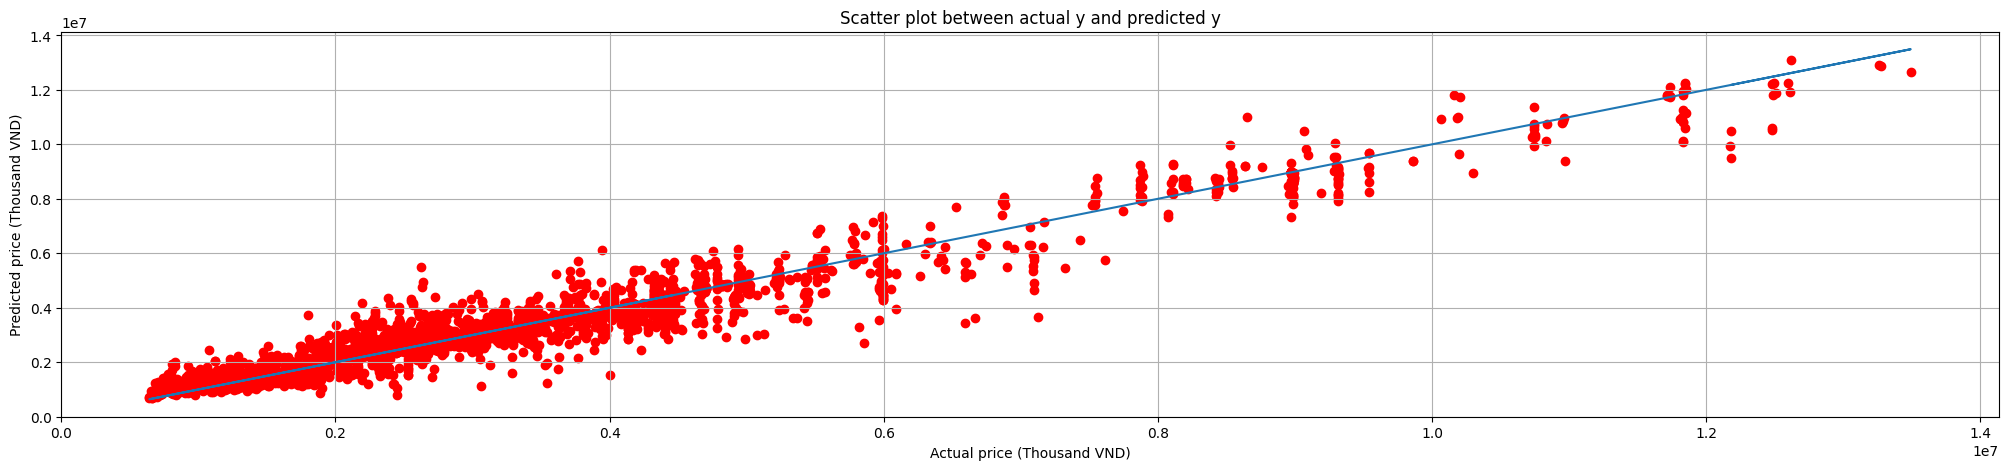

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [16]:
rdf = ModelRandomForest(model = RandomForestRegressor())
rdf.train(X_train, y_train)
rdf_y_pred = rdf.predict(X_val)
rdf_score_mae, rdf_score_rmse, rdf_score_mape, rdf_r2 = rdf.evaluate(y_val)
rdf.plot_yy(25, 5, rdf_y_pred, y_val)
print(rdf.model.get_params())

In [17]:
print(rdf.model.score(X_train, y_train))
print(rdf.model.score(X_val, y_val))

0.9897771797127555
0.9386947544783767


In [18]:
from tabulate import tabulate

def compute_metrics(y_true, y_pred):
    n = len(y_true)
    errors = y_pred - y_true
    mae = np.sum(np.abs(errors)) / n
    mse = np.sum(errors**2) / n
    rmse = np.sqrt(mse)
    return mae, mse, rmse

def train_random_forest(X_train, y_train, X_val, y_val,
                        n_estimators=100, max_depth=None, random_state=0):
    """
    Huấn luyện RandomForestRegressor và in metrics.
    Trả về model đã train.
    """
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=random_state
    )
    model.fit(X_train, y_train)
    
    # Dự đoán trên train & val
    y_train_pred = model.predict(X_train)
    # y_val_pred  = model.predict(X_val)
    
    # Tính metrics
    tr_mae, tr_mse, tr_rmse = compute_metrics(y_train, y_train_pred)
    # te_mae, te_mse, te_rmse = compute_metrics(y_val, y_val_pred)
    
    print(f"RandomForest (n_estimators={n_estimators}, max_depth={max_depth})")
    print(f" Train MAE={tr_mae:.2f}, MSE={tr_mse:.2f}, RMSE={tr_rmse:.2f}")
    # print(f" val  MAE={te_mae:.2f}, MSE={te_mse:.2f}, RMSE={te_rmse:.2f}")
    
    return model

def predict(ml_model, x_train, x_val):
    print('Model: {}'.format(ml_model))
    table = []
    headers = ['Metrics', 'Values']
    
    model = ml_model.fit(x_train, y_train)
    
    training_score = model.score(x_train, y_train)
    valing_score = model.score(x_val, y_val)
    table.append(['Training score', training_score])
    table.append(['valing score', valing_score])
    
    predictions = model.predict(x_val)
    
    MAE = mean_absolute_error(y_val, predictions)
    MSE = mean_squared_error(y_val, predictions)
    RMSE = np.sqrt(MSE)
    
    table.append(['MAE', MAE]) 
    table.append(['MSE', MSE]) 
    table.append(['RMSE', RMSE])
    
    print(tabulate(table, headers=headers, tablefmt='fancy_grid', numalign='right', floatfmt=".2f"))
    
    return predictions, training_score, valing_score, MAE, MSE, RMSE

# Ví dụ sử dụng:
# rf = train_random_forest(X_train, y_train, X_val, y_val,
#                          n_estimators=200, max_depth=10)
# y_pred = predict(rf, X_val)


In [19]:
def plot(predictions):
    sns.distplot(y_val-predictions)
    
    fig1, ax = plt.subplots(1, 1, figsize=(20, 5))

    ax.plot([i for i in range(250)], y_val[0:250],  color='blue')
    ax.plot([i for i in range(250)], predictions[0:250], color='orange')

    ax.set_ylabel("Price (VND)")
    ax.legend(['true price', 'predict price'])

    fig1.show()
    
    fig2, ax = plt.subplots(1, 1, figsize=(20, 5))

    ax.scatter([i for i in range(250)], y_val[0:250],  color='blue', linewidths=4)
    ax.scatter([i for i in range(250)], predictions[0:250], color='orange', linewidths=3)
    
    ax.set_ylabel("Price (VND)")
    ax.legend(['true price', 'predict price'])
    
    fig2.show()

RandomForest (n_estimators=100, max_depth=None)
 Train MAE=132973.74, MSE=45237819292.40, RMSE=212691.84
Model: RandomForestRegressor(random_state=0)


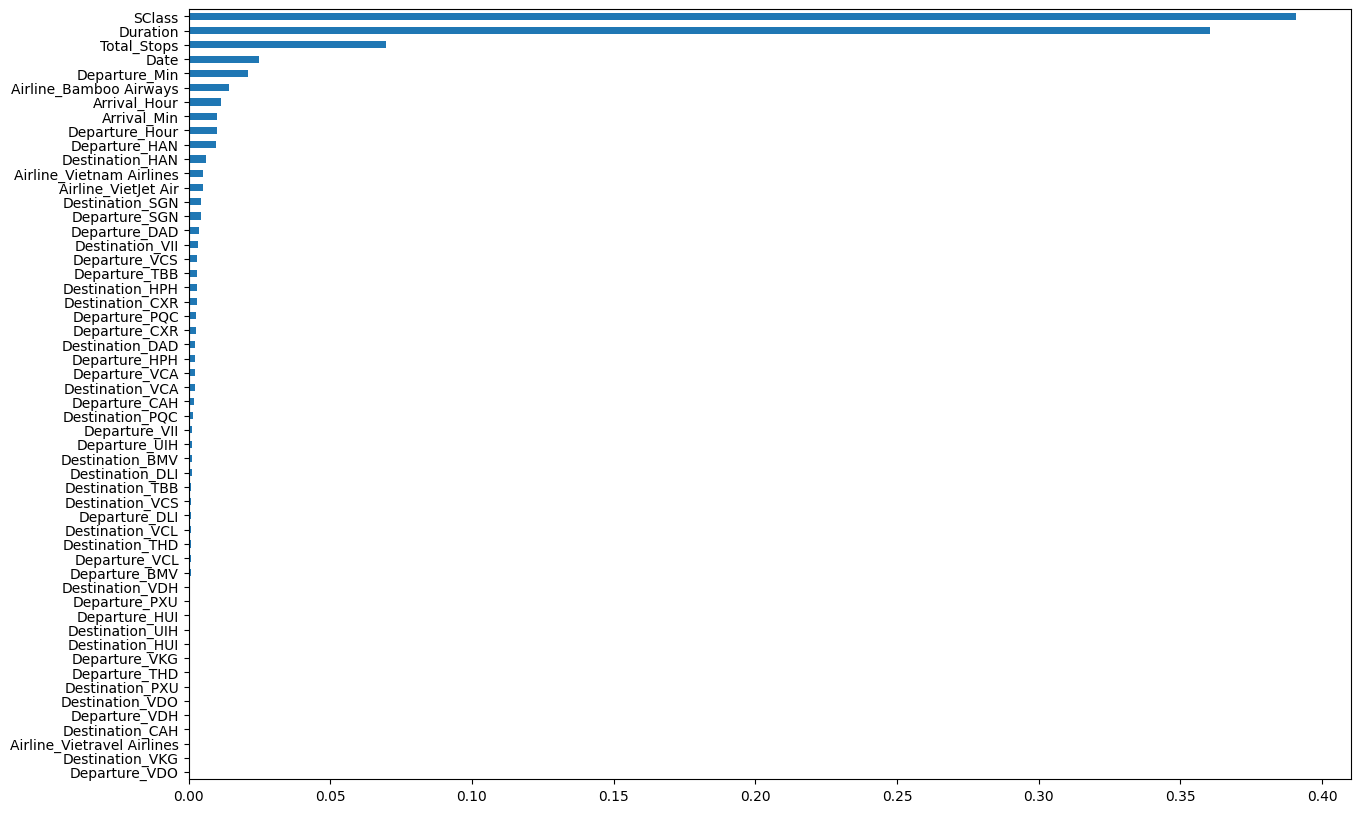

In [20]:
rf = train_random_forest(X_train, y_train, X_val, y_val)
feature_importance(rf)

Model: RandomForestRegressor(random_state=0)
╒════════════════╤═════════════════╕
│ Metrics        │          Values │
╞════════════════╪═════════════════╡
│ Training score │            0.99 │
├────────────────┼─────────────────┤
│ valing score   │            0.94 │
├────────────────┼─────────────────┤
│ MAE            │       341418.36 │
├────────────────┼─────────────────┤
│ MSE            │ 284335791877.39 │
├────────────────┼─────────────────┤
│ RMSE           │       533231.46 │
╘════════════════╧═════════════════╛


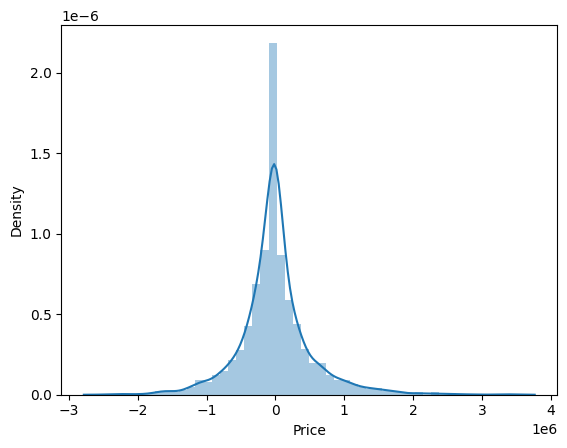

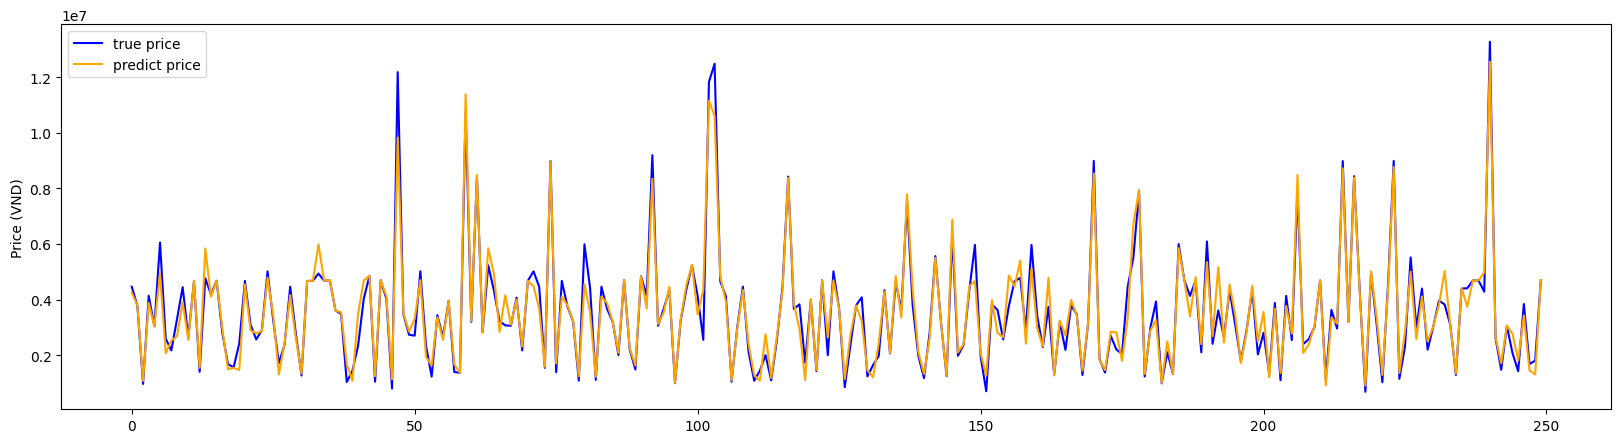

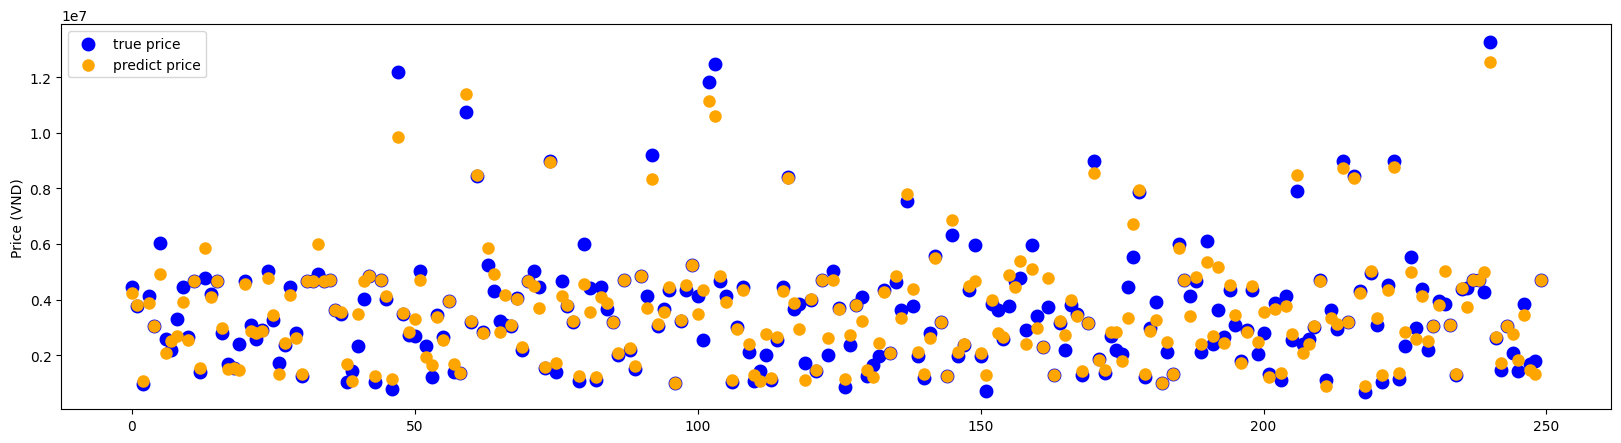

In [21]:
predictions_rf, training_score_rf, testing_score_rf, MAE_rf, MSE_rf, RMSE_rf = predict(rf, X_train, X_val)
plot(predictions_rf)

- Random Forest nhìn chung cho dự đoán tốt hơn

Model: RandomForestRegressor(random_state=0)
╒════════════════╤═════════════════╕
│ Metrics        │          Values │
╞════════════════╪═════════════════╡
│ Training score │            0.83 │
├────────────────┼─────────────────┤
│ valing score   │            0.81 │
├────────────────┼─────────────────┤
│ MAE            │       668750.74 │
├────────────────┼─────────────────┤
│ MSE            │ 857989904655.67 │
├────────────────┼─────────────────┤
│ RMSE           │       926277.44 │
╘════════════════╧═════════════════╛


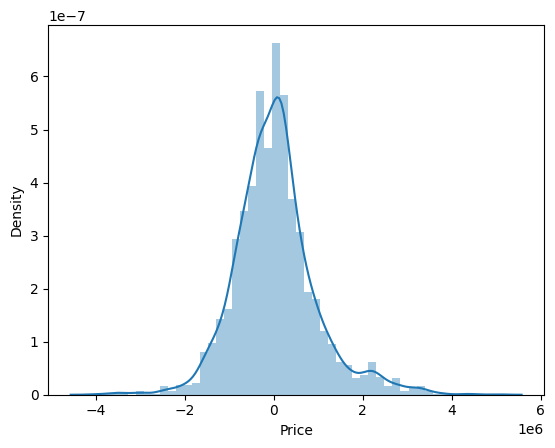

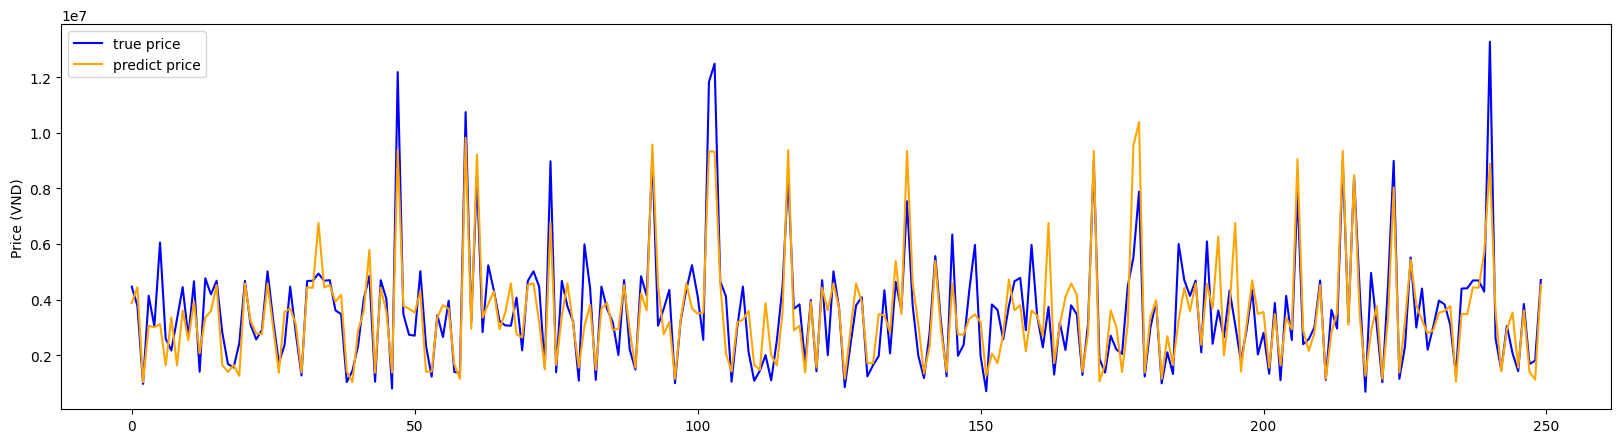

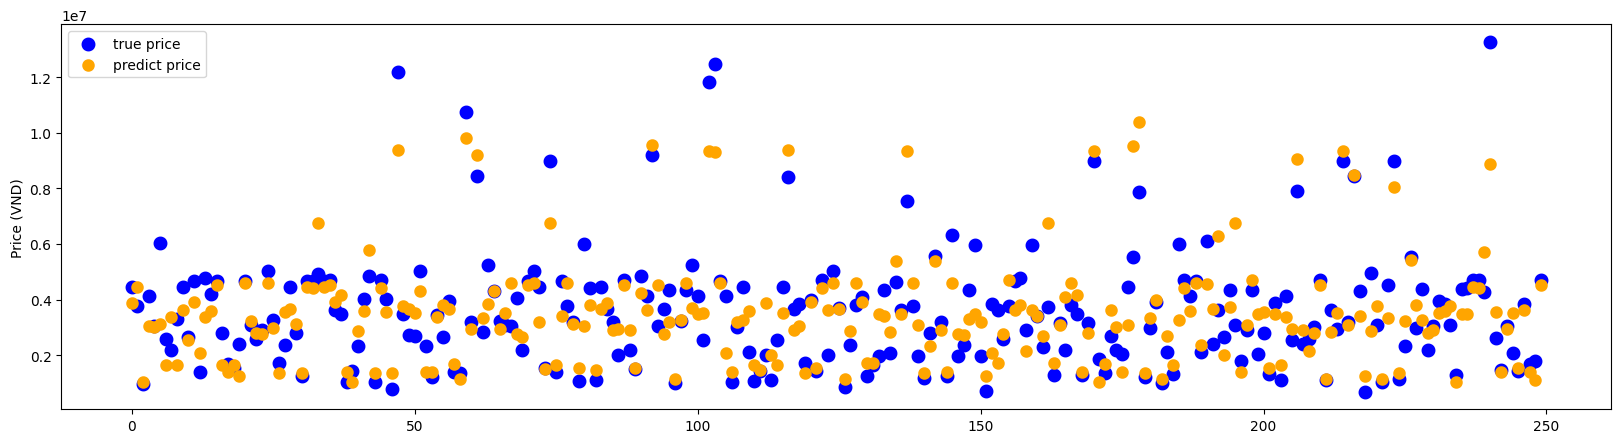

In [22]:
x_train_rf = X_train[['SClass', 'Duration', 'Total_Stops']]
x_val_rf = X_val[['SClass', 'Duration', 'Total_Stops']]

predictions_rf_fs, training_score_rf_fs, valing_score_rf_fs, MAE_rf_fs, MSE_rf_fs, RMSE_rf_fs = predict(rf, x_train_rf, x_val_rf)
plot(predictions_rf_fs)

In [23]:
print('Model: {}'.format(rf))
table_rf = []
table_rf.append(['', 'Without Feature Selection', 'With Feature Selection'])
table_rf.append(['Training score', training_score_rf, training_score_rf_fs])
table_rf.append(['Testing score', testing_score_rf, valing_score_rf_fs])
table_rf.append(['MAE', MAE_rf, MAE_rf_fs])
table_rf.append(['MSE', MSE_rf, MSE_rf_fs])
table_rf.append(['RMSE', RMSE_rf, RMSE_rf_fs])
print(tabulate(table_rf, headers='firstrow', tablefmt='fancy_grid', numalign='right', floatfmt=".2f"))

Model: RandomForestRegressor(random_state=0)
╒════════════════╤═════════════════════════════╤══════════════════════════╕
│                │   Without Feature Selection │   With Feature Selection │
╞════════════════╪═════════════════════════════╪══════════════════════════╡
│ Training score │                        0.99 │                     0.83 │
├────────────────┼─────────────────────────────┼──────────────────────────┤
│ Testing score  │                        0.94 │                     0.81 │
├────────────────┼─────────────────────────────┼──────────────────────────┤
│ MAE            │                   341418.36 │                668750.74 │
├────────────────┼─────────────────────────────┼──────────────────────────┤
│ MSE            │             284335791877.39 │          857989904655.67 │
├────────────────┼─────────────────────────────┼──────────────────────────┤
│ RMSE           │                   533231.46 │                926277.44 │
╘════════════════╧═════════════════════════

In [38]:
param_grid_rf = {
    'n_estimators': [200, 500, 1000],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,
    n_iter=30,  # thử 30 tổ hợp thay vì 162
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE
)

random_search.fit(X_train, y_train)


best_hyperparams_rf = random_search.best_params_

print('Best hyperparameters for model {}: {}'.format(rf, best_hyperparams_rf))

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters for model RandomForestRegressor(random_state=0): {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 15}


Model: RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=5,
                      n_estimators=200, random_state=42)
╒════════════════╤═════════════════╕
│ Metrics        │          Values │
╞════════════════╪═════════════════╡
│ Training score │            0.92 │
├────────────────┼─────────────────┤
│ valing score   │            0.90 │
├────────────────┼─────────────────┤
│ MAE            │       523105.08 │
├────────────────┼─────────────────┤
│ MSE            │ 477780455922.79 │
├────────────────┼─────────────────┤
│ RMSE           │       691216.65 │
╘════════════════╧═════════════════╛


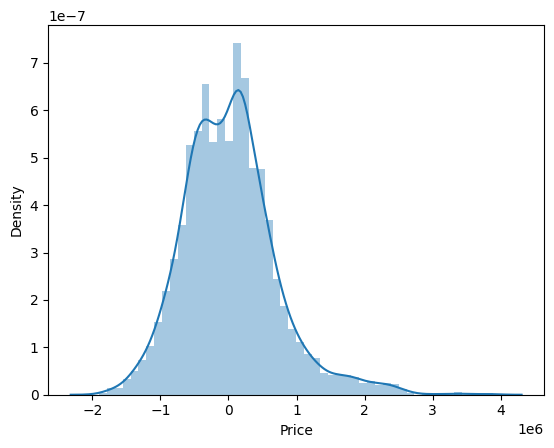

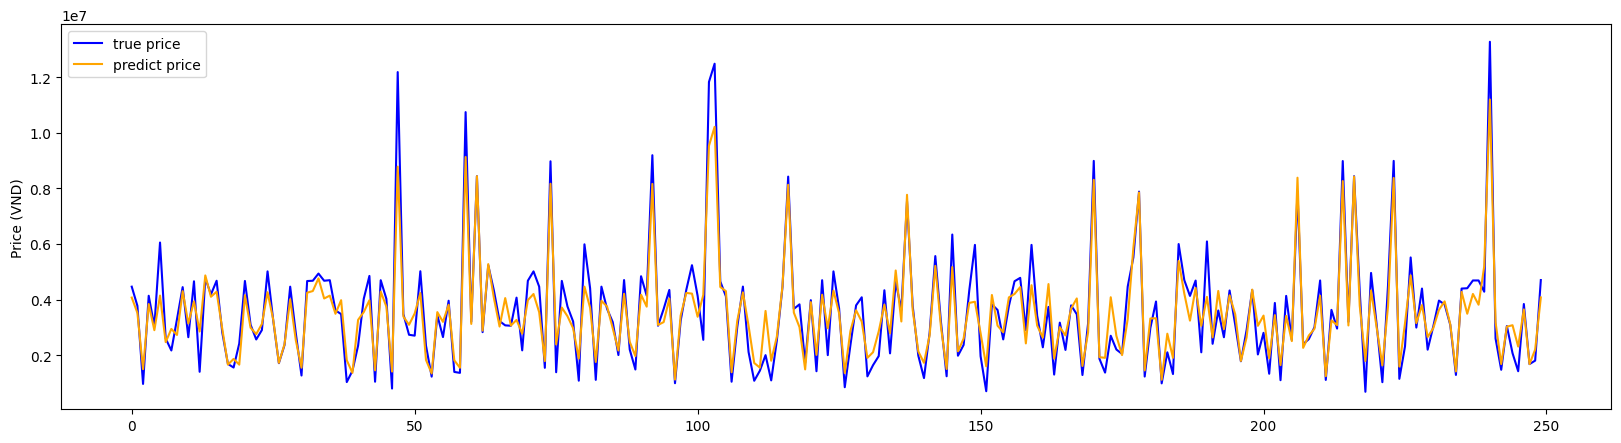

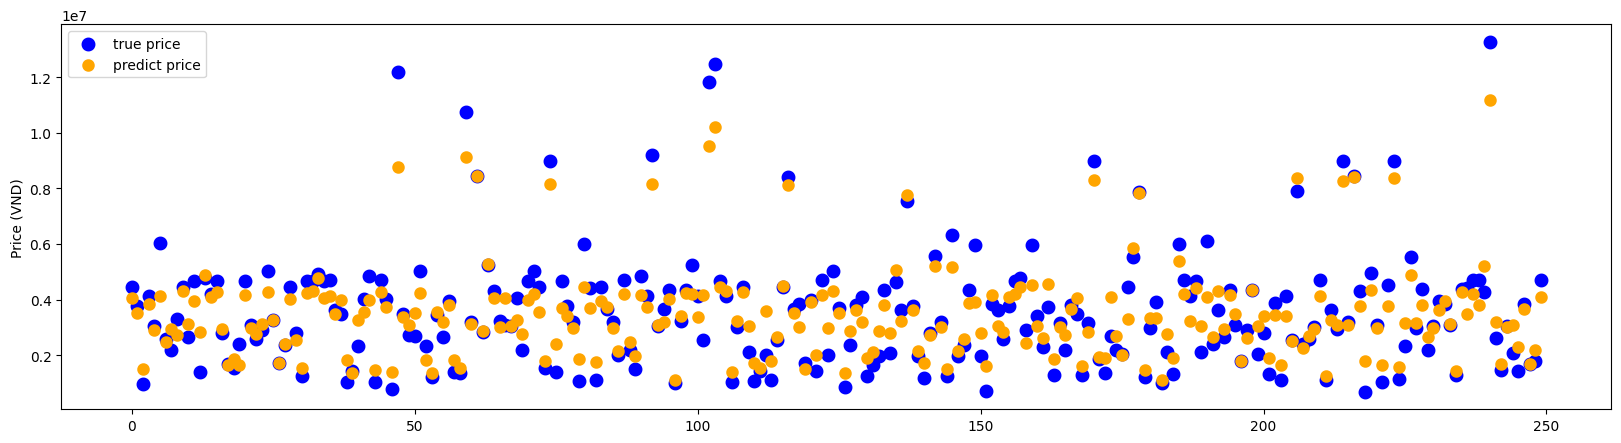

In [39]:
rf_hyper = RandomForestRegressor(**best_hyperparams_rf, random_state=42)
predictions_rf_hyper, training_score_rf_hyper, testing_score_rf_hyper, MAE_rf_hyper, MSE_rf_hyper, RMSE_rf_hyper = predict(rf_hyper, X_train, X_val)
plot(predictions_rf_hyper)

Model: RandomForestRegressor(max_depth=15, max_features='sqrt', min_samples_split=5,
                      n_estimators=200, random_state=42)
╒════════════════╤═════════════════╕
│ Metrics        │          Values │
╞════════════════╪═════════════════╡
│ Training score │            0.83 │
├────────────────┼─────────────────┤
│ valing score   │            0.81 │
├────────────────┼─────────────────┤
│ MAE            │       668656.91 │
├────────────────┼─────────────────┤
│ MSE            │ 855725658623.05 │
├────────────────┼─────────────────┤
│ RMSE           │       925054.41 │
╘════════════════╧═════════════════╛


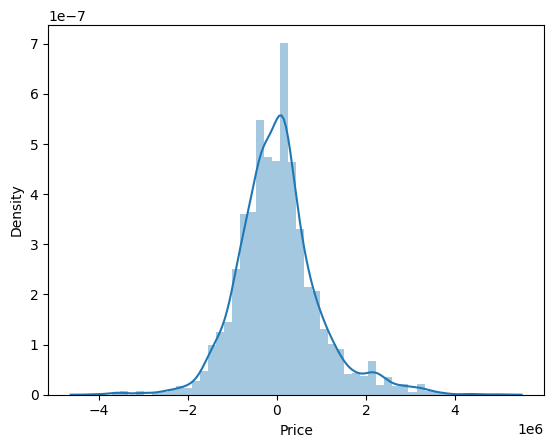

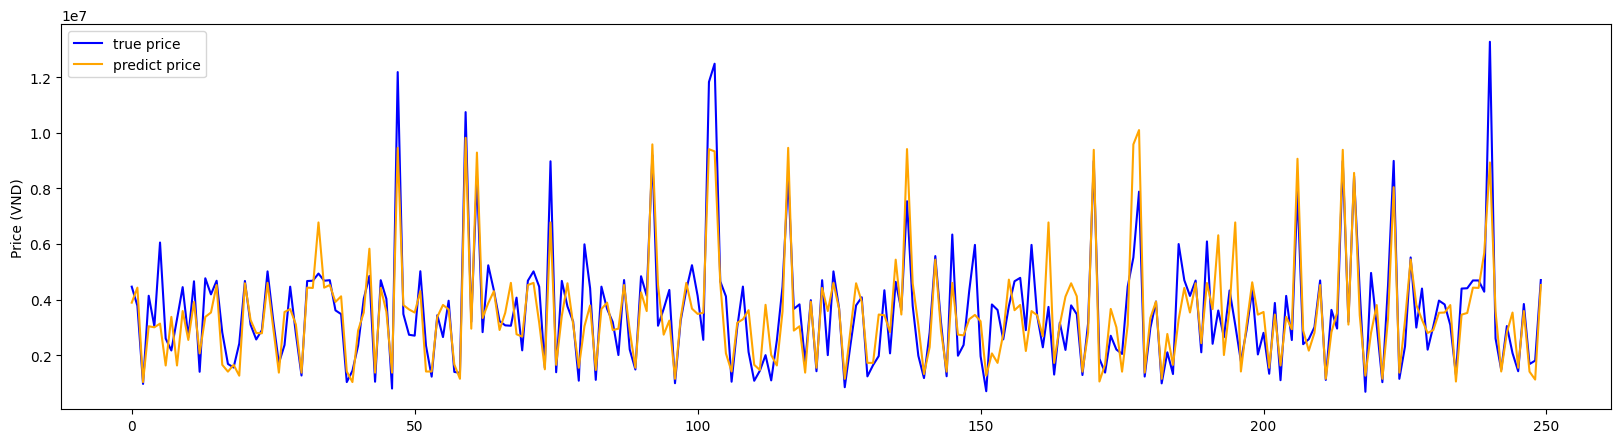

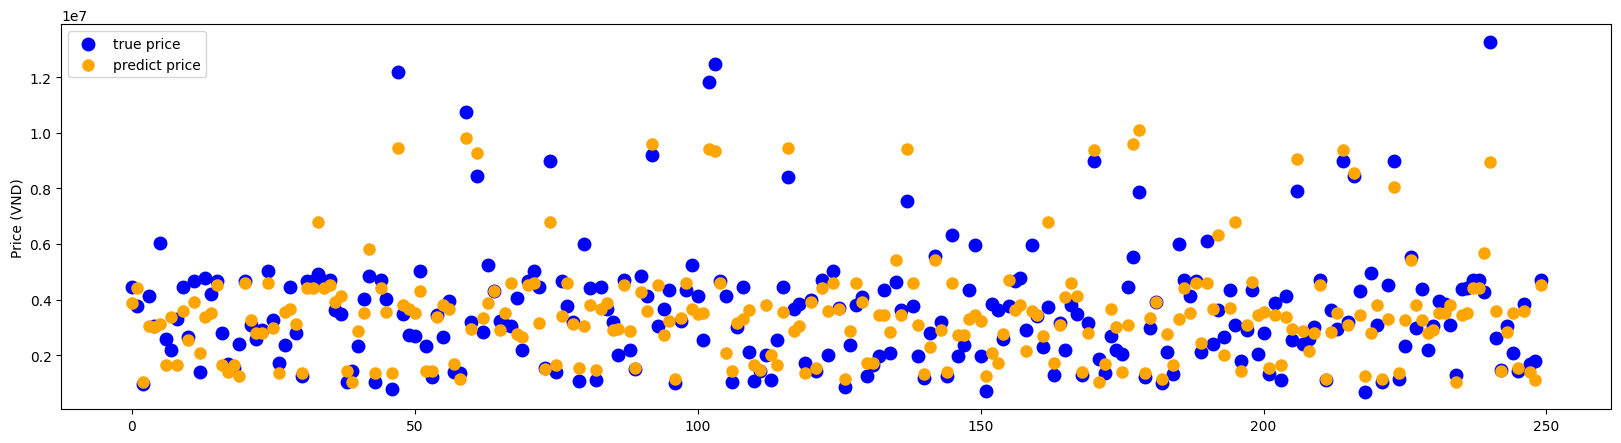

In [40]:
rf_hyper = RandomForestRegressor(**best_hyperparams_rf, random_state=42)
predictions_rf_hyper, training_score_rf_hyper, testing_score_rf_hyper, MAE_rf_hyper, MSE_rf_hyper, RMSE_rf_hyper = predict(rf_hyper, X_train_rf, X_val_rf)
plot(predictions_rf_hyper)

### Thực hiện cross-validation

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
make_scorer(r2_score, response_method='predict')
MAE: 338479.99973561737
RMSE: 524715.29174665
MAPE: 0.11989167513979822
R2: 0.9399149239836915


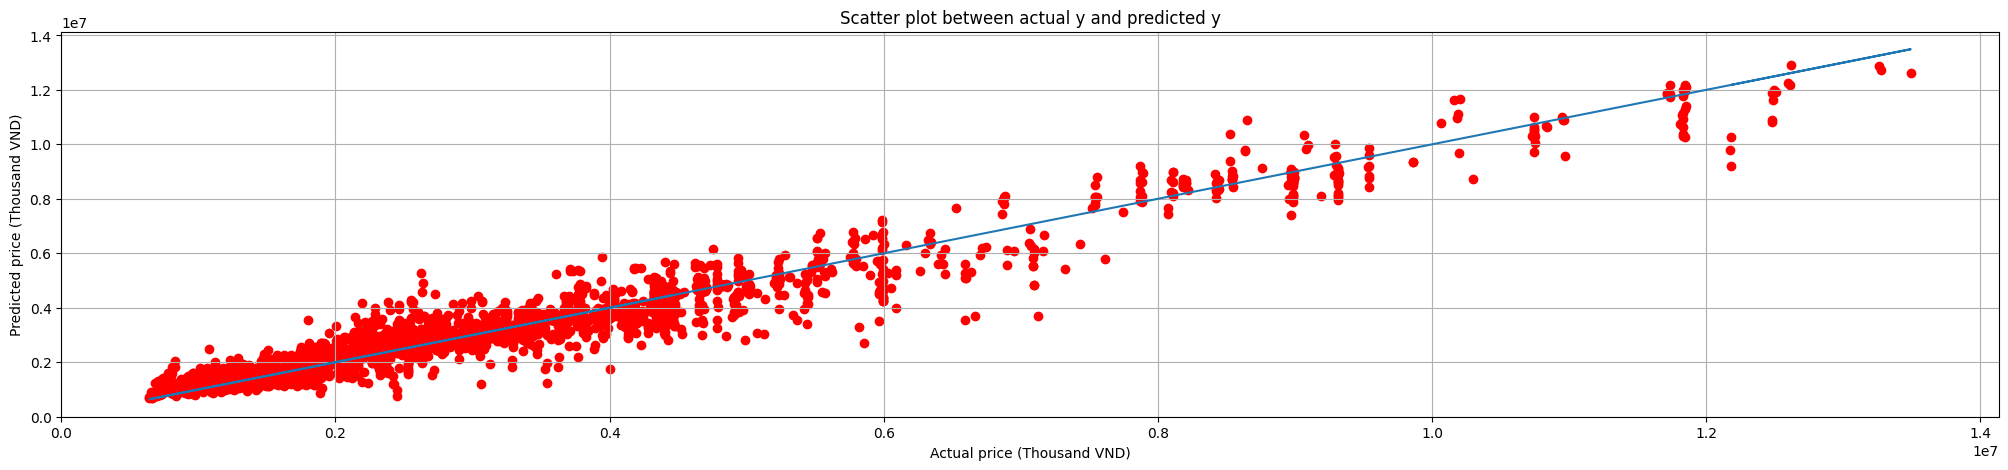

{'bootstrap': True, 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}


In [41]:
rdf_xg = ModelRandomForest(model = RandomForestRegressor(), search = True)
rdf_xg.train(X_train, y_train)
rdf_xg_y_pred = rdf_xg.predict(X_val)
rdf_score_mae, rdf_score_rmse, rdf_score_mape, rdf_r2 = rdf_xg.evaluate(y_val)
rdf_xg.plot_yy(25, 5, rdf_xg_y_pred, y_val)
print(rdf_xg.params)

In [42]:
print(rdf_xg.model.score(X_train, y_train))
print(rdf_xg.model.score(X_val, y_val))

0.9839289394887673
0.9399149239836915


## Triển khai mô hình trên Test data

### Thực hiện feature engineering trên data test

In [70]:
X_test = testset.drop(["Price"] , axis=1)
selected_features = ['SClass', 'Duration', 'Total_Stops']
X_test_rf = X_test[selected_features]
y_test_rf = testset["Price"]
X_test_rf = X_test_rf.reset_index(drop=True)
y_test_rf = y_test.reset_index(drop=True)

### Chuẩn hóa các biến số thực

In [71]:
X_test_scaled = scaler.fit_transform(X_test)
X_test_scaled

array([[ 0.8385168 , -0.06694717,  1.09166808, ..., -0.12811374,
        -0.25498388, -0.02807726],
       [-0.9052105 , -1.03548764, -0.83315502, ..., -0.12811374,
        -0.25498388, -0.02807726],
       [ 1.00804585, -0.55121741,  1.09166808, ..., -0.12811374,
        -0.25498388, -0.02807726],
       ...,
       [ 0.59633245, -1.03548764,  1.09166808, ..., -0.12811374,
        -0.25498388, -0.02807726],
       [ 0.69320619, -1.03548764,  1.09166808, ..., -0.12811374,
        -0.25498388, -0.02807726],
       [ 0.2088375 , -0.55121741,  1.09166808, ..., -0.12811374,
        -0.25498388, -0.02807726]])

### Kết quả thực thi mô hình

### Random Forest

Default model

In [75]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
# plot(y_pred)

In [76]:
test_r2  = rf.score(X_test,  y_test)

# Compute error metrics on the test set
mae   = mean_absolute_error(y_test, y_pred)
mse   = mean_squared_error(y_test, y_pred)
rmse  = np.sqrt(mse)
r2    = r2_score(y_test, y_pred)

print(f"Test R²:  {test_r2:.3f}")
print(f"MAE:       {mae:.3f}")
print(f"MSE:       {mse:.3f}")
print(f"RMSE:      {rmse:.3f}")
print(f"R² (alt):  {r2:.3f}")

Test R²:  0.933
MAE:       352839.141
MSE:       297979645609.979
RMSE:      545875.119
R² (alt):  0.933


Default model with selected feature

In [77]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_rf, y_train)
y_pred_rf = rf.predict(X_test_rf)
# plot(y_pred)

In [78]:
test_r2  = rf.score(X_test_rf,  y_test)

# Compute error metrics on the test set
mae   = mean_absolute_error(y_test, y_pred_rf)
mse   = mean_squared_error(y_test, y_pred_rf)
rmse  = np.sqrt(mse)
r2    = r2_score(y_test, y_pred_rf)

print(f"Test R²:  {test_r2:.3f}")
print(f"MAE:       {mae:.3f}")
print(f"MSE:       {mse:.3f}")
print(f"RMSE:      {rmse:.3f}")
print(f"R² (alt):  {r2:.3f}")

Test R²:  0.819
MAE:       641906.349
MSE:       800472003306.162
RMSE:      894691.010
R² (alt):  0.819


Optimized model with default feature

In [79]:
rf_tuned = RandomForestRegressor(**best_hyperparams_rf,random_state=42)
rf_tuned.fit(X_train, y_train)
y_pred_rf_tuned = rf_tuned.predict(X_test)
# plot(y_pred)

In [81]:
test_r2  = rf_tuned.score(X_test,  y_test)

# Compute error metrics on the test set
mae   = mean_absolute_error(y_test, y_pred_rf_tuned)
mse   = mean_squared_error(y_test, y_pred_rf_tuned)
rmse  = np.sqrt(mse)
r2    = r2_score(y_test, y_pred_rf_tuned)

print(f"Test R²:  {test_r2:.3f}")
print(f"MAE:       {mae:.3f}")
print(f"MSE:       {mse:.3f}")
print(f"RMSE:      {rmse:.3f}")
print(f"R² (alt):  {r2:.3f}")

Test R²:  0.896
MAE:       516984.025
MSE:       460127430327.958
RMSE:      678326.935
R² (alt):  0.896


Optimized model with selected feature

In [84]:
rf_tuned_s = RandomForestRegressor(**best_hyperparams_rf,random_state=42)
rf_tuned_s.fit(X_train_rf, y_train)
y_pred_rf_tuned_s = rf_tuned_s.predict(X_test_rf)
# plot(y_pred)

In [87]:
test_r2  = rf_tuned_s.score(X_test_rf,  y_test)

# Compute error metrics on the test set
mae   = mean_absolute_error(y_test, y_pred_rf_tuned_s)
mse   = mean_squared_error(y_test, y_pred_rf_tuned_s)
rmse  = np.sqrt(mse)
r2    = r2_score(y_test, y_pred_rf_tuned_s)

print(f"Test R²:  {test_r2:.3f}")
print(f"MAE:       {mae:.3f}")
print(f"MSE:       {mse:.3f}")
print(f"RMSE:      {rmse:.3f}")
print(f"R² (alt):  {r2:.3f}")

Test R²:  0.819
MAE:       641507.040
MSE:       797748738731.806
RMSE:      893167.811
R² (alt):  0.819
